In [ ]:
# 1) Import & path (taruh 3 file .xlsx di folder yang sama dengan notebook)
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

BASE = Path.cwd()

PATH_LISTRIK  = BASE / "proporsi-sekolah-dengan-akses-ke-listrik-pada-jenjang-sd.xlsx"
PATH_KOMPUTER = BASE / "jumlah-sd-yang-memiliki-fasilitas-komputer-untuk-tujuan-pengajaran-2024.xlsx"
PATH_RUANG    = BASE / "jumlah-ruang-kelas-menurut-kondisi-tiap-provinsi-sd-2023.xlsx"

print("Folder kerja:", BASE.resolve())
print("Listrik  :", PATH_LISTRIK.exists(), PATH_LISTRIK.name)
print("Komputer :", PATH_KOMPUTER.exists(), PATH_KOMPUTER.name)
print("Ruang    :", PATH_RUANG.exists(), PATH_RUANG.name)


Folder kerja: D:\file kuliah S5\Applied Machine\TUGAS BESAR APPLIED MACHINE LEARNING
Listrik  : True proporsi-sekolah-dengan-akses-ke-listrik-pada-jenjang-sd.xlsx
Komputer : True jumlah-sd-yang-memiliki-fasilitas-komputer-untuk-tujuan-pengajaran-2024.xlsx
Ruang    : True jumlah-ruang-kelas-menurut-kondisi-tiap-provinsi-sd-2023.xlsx


In [2]:
# 2) Fungsi ringkas (baca excel portal + normalisasi provinsi + numerik + agregasi)
def read_portal_xlsx(path, sheet=0, scan_rows=25):
    raw = pd.read_excel(path, sheet_name=sheet, header=None)
    best_i, best_s = 0, -1
    for i in range(min(scan_rows, len(raw))):
        row = raw.iloc[i].astype(str).str.lower().fillna("")
        text = " | ".join(row.tolist())
        score = sum(k in text for k in ["provinsi","wilayah","kabupaten","kota"]) * 10 + row.replace("nan","").astype(bool).sum()
        if score > best_s:
            best_i, best_s = i, score
    df = raw.iloc[best_i+1:].copy()
    df.columns = [str(c).strip() for c in raw.iloc[best_i].tolist()]
    df = df.dropna(how="all")
    df = df.loc[:, [c for c in df.columns if not str(c).lower().startswith("unnamed")]]
    return df

def pick_region_col(cols):
    for k in ["provinsi","wilayah","kabupaten/kota","kabupaten","kota","nama provinsi"]:
        for c in cols:
            if k in str(c).lower():
                return c
    return cols[0]

def norm_prov(x):
    if pd.isna(x): 
        return np.nan
    x = re.sub(r"\s+", " ", str(x).strip().upper())
    x = re.sub(r"^PROV\.?\s*", "", x)        # hapus "PROV." / "PROV"
    x = re.sub(r"^PROVINSI\s*", "", x)        # hapus "PROVINSI"
    # normalisasi nama khusus
    x = x.replace("D.I. YOGYAKARTA", "DAERAH ISTIMEWA YOGYAKARTA")
    x = x.replace("DI YOGYAKARTA", "DAERAH ISTIMEWA YOGYAKARTA")
    x = x.replace("KEPULAUAN BANGKA BELITUNG", "KEP. BANGKA BELITUNG")
    x = x.replace("KEPULAUAN RIAU", "KEP. RIAU")
    return x

def to_num(s):
    s = s.astype(str).str.replace(",", ".", regex=False).str.replace("%","", regex=False)
    s = s.str.replace(r"[^0-9\.\-]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def numeric_df(df, drop_cols=("PROVINSI","WILAYAH_RAW")):
    out = {}
    for c in df.columns:
        if c in drop_cols: 
            continue
        v = to_num(df[c])
        if v.notna().mean() > 0.4:
            out[c] = v
    return pd.DataFrame(out)

def agg_to_prov(df_num, prefix):
    # sum untuk "jumlah", mean untuk "proporsi/persen" (lihat nama kolom)
    agg = {}
    for c in df_num.columns:
        if c == "PROVINSI":
            continue
        cl = c.lower()
        agg[c] = "mean" if ("proporsi" in cl or "persen" in cl or "%" in cl) else "sum"
    out = df_num.groupby("PROVINSI", as_index=False).agg(agg)
    out = out.add_prefix(prefix).rename(columns={f"{prefix}PROVINSI":"PROVINSI"})
    out = out.dropna(axis=1, how="all")  # buang kolom 100% NaN
    return out


In [3]:
# 3) Load → rapikan → agregasi provinsi → merge (hindari NaN hasil merge)
listrik  = read_portal_xlsx(PATH_LISTRIK)
komputer = read_portal_xlsx(PATH_KOMPUTER)
ruang    = read_portal_xlsx(PATH_RUANG)

# kolom wilayah
col_lis = pick_region_col(listrik.columns)
col_kom = pick_region_col(komputer.columns)
col_rua = pick_region_col(ruang.columns)

for df, col in [(listrik,col_lis),(komputer,col_kom),(ruang,col_rua)]:
    df["WILAYAH_RAW"] = df[col]
    df["PROVINSI"] = df["WILAYAH_RAW"].map(norm_prov)

# numerik
lis_num = pd.concat([listrik[["PROVINSI"]],  numeric_df(listrik)],  axis=1).dropna(subset=["PROVINSI"])
kom_num = pd.concat([komputer[["PROVINSI"]], numeric_df(komputer)], axis=1).dropna(subset=["PROVINSI"])
rua_num = pd.concat([ruang[["PROVINSI"]],    numeric_df(ruang)],    axis=1).dropna(subset=["PROVINSI"])

# buang baris non-provinsi (kalau muncul)
for df in (lis_num, kom_num, rua_num):
    df.drop(df[df["PROVINSI"].isin(["LUAR NEGERI","INDONESIA","TOTAL"])].index, inplace=True)

lis_prov = agg_to_prov(lis_num, "LIS_")
kom_prov = agg_to_prov(kom_num, "KOM_")
rua_prov = agg_to_prov(rua_num, "RUANG_")

# merge
df = rua_prov.merge(lis_prov, on="PROVINSI", how="left").merge(kom_prov, on="PROVINSI", how="left")

# kalau masih ada kolom yang semua NaN, buang
all_nan_cols = [c for c in df.columns if c != "PROVINSI" and df[c].isna().all()]
if all_nan_cols:
    print("Kolom dibuang (100% NaN):", all_nan_cols)
    df = df.drop(columns=all_nan_cols)

# isi NaN sisanya dengan median
for c in df.columns:
    if c != "PROVINSI" and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("Shape akhir:", df.shape)
print("Total NaN (harus 0):", int(df.isna().sum().sum()))
df.head()


Shape akhir: (40, 18)
Total NaN (harus 0): 0


,PROVINSI,RUANG_Baik,RUANG_Rusak Ringan,RUANG_Rusak Sedang,RUANG_Rusak Berat,RUANG_Jumlah,LIS_No,LIS_Kode Kemdagri,LIS_Kode BPS,LIS_Tersedia,LIS_Tidak tersedia,LIS_Persentase Tersedia,KOM_No,KOM_Kode Kemdagri,KOM_Kode BPS,KOM_Status Satuan Pendidikan,KOM_nan,KOM_Total
0,ACEH,10261.0,7483.0,6076.0,3122.0,26942.0,276.0,25836.0,25836.0,3513.0,16.0,99.581591,1.0,11.0,11.0,303.0,31.0,334.0
1,BALI,8646.0,4835.0,3042.0,1142.0,17665.0,2502.0,46007.0,46007.0,2416.0,0.0,100.000000,17.0,51.0,51.0,79.0,97.0,176.0
2,BANTEN,20757.0,10581.0,6117.0,3434.0,40889.0,2156.0,29100.0,29100.0,4628.0,6.0,99.900044,16.0,36.0,36.0,361.0,444.0,805.0
3,BENGKULU,4232.0,3371.0,3359.0,717.0,11679.0,1205.0,17116.0,17116.0,1379.0,19.0,98.570134,7.0,17.0,17.0,99.0,23.0,122.0
4,D.K.I. JAKARTA,23320.0,3886.0,717.0,345.0,28268.0,945.0,18966.0,18966.0,2237.0,2.0,99.934165,20.0,61.0,61.0,125.0,45.0,169.0


In [4]:
# 4) Label "Prioritas Perbaikan" (Rendah/Sedang/Tinggi) dari skor
features = [c for c in df.columns if c != "PROVINSI"]
X = df[features].copy()

mm = MinMaxScaler()
Xn = pd.DataFrame(mm.fit_transform(X), columns=features)

risk_cols = [c for c in features if re.search(r"rusak|buruk|berat|sedang", c.lower())]
good_cols = [c for c in features if "baik" in c.lower()]
if not risk_cols:
    risk_cols = features

score = Xn[risk_cols].mean(axis=1)
if good_cols:
    score = score - Xn[good_cols].mean(axis=1)

df["PRIORITY_SCORE"] = score
q1, q2 = df["PRIORITY_SCORE"].quantile([0.33, 0.66])

def label_prioritas(v):
    if v <= q1: return "Prioritas Rendah"
    if v <= q2: return "Prioritas Sedang"
    return "Prioritas Tinggi"

df["PRIORITAS_PERBAIKAN_SARPRAS"] = df["PRIORITY_SCORE"].apply(label_prioritas)
print(df["PRIORITAS_PERBAIKAN_SARPRAS"].value_counts())
df[["PROVINSI","PRIORITY_SCORE","PRIORITAS_PERBAIKAN_SARPRAS"]].sort_values("PRIORITY_SCORE", ascending=False).head(10)


PRIORITAS_PERBAIKAN_SARPRAS
Prioritas Tinggi    14
Prioritas Sedang    13
Prioritas Rendah    13
Name: count, dtype: int64


,PROVINSI,PRIORITY_SCORE,PRIORITAS_PERBAIKAN_SARPRAS
8,JAWA BARAT,0.802691,Prioritas Tinggi
9,JAWA TENGAH,0.704242,Prioritas Tinggi
10,JAWA TIMUR,0.684114,Prioritas Tinggi
37,SUMATERA UTARA,0.402976,Prioritas Tinggi
31,SULAWESI SELATAN,0.299019,Prioritas Tinggi
22,NUSA TENGGARA TIMUR,0.296371,Prioritas Tinggi
18,LAMPUNG,0.216954,Prioritas Tinggi
36,SUMATERA SELATAN,0.193113,Prioritas Tinggi
11,KALIMANTAN BARAT,0.190604,Prioritas Tinggi
35,SUMATERA BARAT,0.185679,Prioritas Tinggi


Accuracy: 1.0
Macro-F1: 1.0

                   precision    recall  f1-score   support

Prioritas Rendah       1.00      1.00      1.00         3
Prioritas Sedang       1.00      1.00      1.00         3
Prioritas Tinggi       1.00      1.00      1.00         4

        accuracy                           1.00        10
       macro avg       1.00      1.00      1.00        10
    weighted avg       1.00      1.00      1.00        10



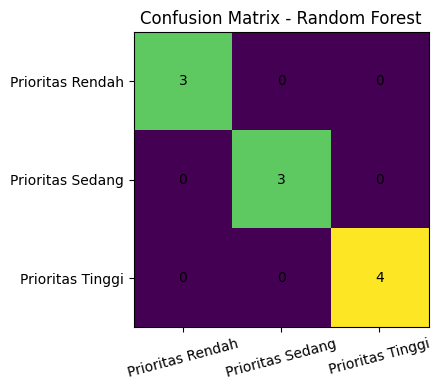

CV F1-macro: [1.         0.86666667 1.         1.         0.88571429] Mean: 0.9504761904761905
Saved to: D:\file kuliah S5\Applied Machine\TUGAS BESAR APPLIED MACHINE LEARNING\output


In [5]:
# 5) Random Forest + evaluasi + simpan file (output/)
y = df["PRIORITAS_PERBAIKAN_SARPRAS"]
X = df[features]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced")
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)

print("Accuracy:", accuracy_score(y_te, pred))
print("Macro-F1:", f1_score(y_te, pred, average="macro"))
print("\n", classification_report(y_te, pred))

labels = ["Prioritas Rendah","Prioritas Sedang","Prioritas Tinggi"]
cm = confusion_matrix(y_te, pred, labels=labels)

plt.figure(figsize=(7,4))
plt.imshow(cm)
plt.xticks(range(3), labels, rotation=15)
plt.yticks(range(3), labels)
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="f1_macro")
print("CV F1-macro:", cv_scores, "Mean:", cv_scores.mean())

# simpan
out_dir = Path("output")
out_dir.mkdir(exist_ok=True)

df.to_csv(out_dir / "sarpras_sd_prioritas_processed.csv", index=False)

import joblib
joblib.dump(rf, out_dir / "rf_prioritas_sarpras_sd.joblib")

print("Saved to:", out_dir.resolve())
